In [ ]:
# @title Load Packages
%pip install sqldf
%pip install statsmodels
import sqldf
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from google.cloud import bigquery
import random as r
import warnings
import matplotlib.pyplot as plt
import datetime, pytz
import os
import math
import time
from datetime import date, datetime, timedelta
from tqdm import tqdm
from scipy.stats import norm, binom
import seaborn as sns
from statsmodels.stats import proportion as prop
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table
"""
`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_tracking_id_level`
`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level`
"""

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


'\nQueries refactored/replicated:\n  new user acquisition query: https://console.cloud.google.com/bigquery?sq=528788838527:300c284b72424f4e9f081640dd74d435\n  existing user query: https://console.cloud.google.com/bigquery?sq=528788838527:6fcaf4ddee9a4c29ae7ba8ceb7ac44ae\n'

In [ ]:
# @title Code to Refresh Directory
# #code to delete all files in directory
# for filename in os.listdir(os.getcwd()):
#     if np.logical_or(filename.endswith(".png"), filename.endswith(".xlsx")):
#         file_path = os.path.join(os.getcwd(), filename)
#         os.remove(file_path) #uncomment to delete csv files in current directory (start over)

In [ ]:
# @title Define Input Variables
def define_variables():
  """
  Description: Instatiates configuration information stored in global variables used in downstream functions

  Returns:
    bq_config_vars: dictionary containing variables needed to connect to appropriate BQ project and dataset
    query_config_vars: dictionary containing variables needed to define experiment data
    variant_vars: maps variant_ids to variant nomenclature (control, variant1, etc.) in a pandas dataframe
  """
  global bq_config_vars, query_config_vars, variant_vars, hyp_test_vars, output_vars
  bq_config_vars = {
    'project_id': 'nbcu-ds-sandbox-a-001',
    'dataset_id': 'nbcu-ds-prod-001'
  }
  query_config_vars = {
    'experiment_id': '25003380671',
    'start_date': '2023-08-09',
    'end_date': '2023-08-29', # Set to None if test is still active,

    # visitor_id for new user acquisition, tracking_id/adobe_tracking_id for existing user f2p conversion
    'unique_identifier_clickstream': 'visitor_id',
    'unique_identifier_page_views': 'visitor_id',

    # define funnel urls, used in define actions function
    'visit_url': 'www.peacocktv.com',
    'click_url': 'checkout/payment',
    'convert_url': '/checkout/success',
    'non_iap_where_clause': ''
  }
  #map variant id to variant nomenclature
  variant_vars = pd.DataFrame({
      'variant_id': ['24953402039', '25022290307'],
      'variant_name': ['control', 'variant_1']
  })

  hyp_test_vars = {'alpha': 0.1}
  output_vars = {
      'experiment_name': 'HP_Anchor_Hero_CTA',
      'value_list':  ['visit', 'click', 'convert',
                'premium_monthly_convert', 'premium_plus_monthly_convert',
                'premium_annual_convert', 'premium_plus_annual_convert',
                'monthly_convert', 'annual_convert',
                'premium_convert', 'premium_plus_convert']
  }
  return (bq_config_vars, query_config_vars, variant_vars, hyp_test_vars, output_vars)

#instantiate variables
define_variables()

({'project_id': 'nbcu-ds-sandbox-a-001', 'dataset_id': 'nbcu-ds-prod-001'},
 {'experiment_id': '25003380671',
  'start_date': '2023-08-09',
  'end_date': '2023-08-29',
  'unique_identifier_clickstream': 'visitor_id',
  'unique_identifier_page_views': 'visitor_id',
  'visit_url': 'www.peacocktv.com',
  'click_url': 'checkout/payment',
  'convert_url': '/checkout/success',
  'non_iap_where_clause': ''},
     variant_id variant_name
 0  24953402039      control
 1  25022290307    variant_1,
 {'alpha': 0.1},
 {'experiment_name': 'HP_Anchor_Hero_CTA',
  'value_list': ['visit',
   'click',
   'convert',
   'premium_monthly_convert',
   'premium_plus_monthly_convert',
   'premium_annual_convert',
   'premium_plus_annual_convert',
   'monthly_convert',
   'annual_convert',
   'premium_convert',
   'premium_plus_convert']})

In [ ]:
# @title Define and Clean Experiment Data
def get_user_level_experiment_data(bq_config_vars, query_config_vars):
  """
  Get users exposed to experiment and their page views during experiment period
  """
  optimizely_query = f"""
  WITH
  u AS (
      SELECT
        {query_config_vars['unique_identifier_clickstream']} AS unique_id,
        mvt_optimizely AS variant,
        LENGTH(mvt_optimizely) - LENGTH(replace(mvt_optimizely, ';', '')) AS additional_variant_count,
        MIN(adobe_date_est) AS bucketed_date
      FROM
        `nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_clickstream_analytics`
      WHERE
        adobe_date_est BETWEEN '{query_config_vars['start_date']}'
        AND '{query_config_vars['end_date']}'
        AND CONTAINS_SUBSTR(mvt_optimizely,'{query_config_vars['experiment_id']}')
        AND {query_config_vars['unique_identifier_clickstream']} IS NOT NULL
        AND service_profile_id IS NOT NULL
        AND post_page_event = '0'
        GROUP BY
        1,2,3
  ),
  pv AS (
    SELECT
      {query_config_vars['unique_identifier_page_views']} AS unique_id,
      STRING_AGG(visitor_entitlement ORDER BY pageview_datetime_est DESC LIMIT 1) AS visitor_entitlement,
      STRING_AGG(billing_cycle ORDER BY pageview_datetime_est DESC LIMIT 1) AS billing_cycle,
      STRING_AGG(url_raw, ' --> ' ORDER BY pageview_datetime_est LIMIT 500) AS url_agg,
      ARRAY_AGG(visitor_registration_ts_est ORDER BY pageview_datetime_est DESC LIMIT 1)[OFFSET(0)] AS visitor_registration_ts_est,
      MIN(pageview_datetime_est) AS session_start_datetime_est,
      COUNT(DISTINCT adobe_tracking_id) AS num_tracking_id
    FROM
      `nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_page_views`
    WHERE
    adobe_date_est BETWEEN '{query_config_vars['start_date']}'
    AND '{query_config_vars['end_date']}'
    GROUP BY
      1
  )
  SELECT
  u.variant,
  u.bucketed_date,
  u.additional_variant_count,
  pv.*,
  CASE WHEN (visitor_registration_ts_est IS NULL OR (session_start_datetime_est <= DATE_ADD(visitor_registration_ts_est, INTERVAL 1 DAY)))
         THEN 'new acquisition' ELSE 'existing' END AS user_status
  FROM
  u
  INNER JOIN
  pv
  ON LOWER(u.unique_id) = LOWER(pv.unique_id)
  WHERE
  1=1
  {query_config_vars['non_iap_where_clause']} -- Exclude Non-IAP Users
  AND num_tracking_id <= 1
  AND bucketed_Date <= DATE(session_start_datetime_est)
  AND u.variant IS NOT NULL
  """
  df  = pd.read_gbq(optimizely_query,project_id = bq_config_vars['project_id'], use_bqstorage_api=True, progress_bar_type = 'tqdm')
  # Split the variant column into two columns using '|'
  df[['experiment_id', 'variant_id']] = df['variant'].str.split('|', expand=True)
  display(df.head(100))
  return(df)

def define_actions(df):
  """
  Perform feature engineering on dataset post-Bigquery retrieval
  """

  #flag if users visited, clicked or converted based on visitation of query_config_vars url
  df['visit'] = df['url_agg'].str.contains(query_config_vars['visit_url'])
  df['click'] = df['url_agg'].str.contains(query_config_vars['visit_url']) & df['url_agg'].str.contains(query_config_vars['click_url'])
  df['convert'] = df['url_agg'].str.contains(query_config_vars['visit_url']) & df['url_agg'].str.contains(query_config_vars['click_url'])\
                                      & df['url_agg'].str.contains(query_config_vars['convert_url'])

  df['premium_monthly_convert'] = df['url_agg'].str.contains(query_config_vars['visit_url']) & df['url_agg'].str.contains(query_config_vars['click_url'])\
                                      & (df['visitor_entitlement'] == 'Premium') * (df['billing_cycle'] == 'MONTHLY')
  df['premium_plus_monthly_convert'] = df['url_agg'].str.contains(query_config_vars['visit_url']) * df['url_agg'].str.contains(query_config_vars['click_url'])\
                                      & (df['visitor_entitlement'] == 'Premium+') & (df['billing_cycle'] == 'MONTHLY')
  df['premium_annual_convert'] = df['url_agg'].str.contains(query_config_vars['visit_url']) * df['url_agg'].str.contains(query_config_vars['click_url'])\
                                      & (df['visitor_entitlement'] == 'Premium') & (df['billing_cycle'] == 'ANNUAL')
  df['premium_plus_annual_convert'] = df['url_agg'].str.contains(query_config_vars['visit_url']) * df['url_agg'].str.contains(query_config_vars['click_url'])\
                                      & (df['visitor_entitlement'] == 'Premium+') & (df['billing_cycle'] == 'ANNUAL')

  df['monthly_convert'] = df['premium_monthly_convert'] + df['premium_plus_monthly_convert']
  df['annual_convert'] = df['premium_annual_convert'] + df['premium_plus_annual_convert']
  df['premium_convert'] = df['premium_monthly_convert']  + df['premium_annual_convert']
  df['premium_plus_convert'] = df['premium_plus_monthly_convert']  + df['premium_plus_annual_convert']
  # map variant name to variant_id
  df_final = df.merge(variant_vars, on = 'variant_id', how = 'left')
  return(df_final)

def remove_users_in_multiple_experiments(df):
  """
  Returns dataframe of users with only 1 variant and 1 bucket date and not in multiple experiments
  Also splits up experiment and variant id
  Maps variant id to variant nomenclature (Control, variant 1, etc.)
  """
  func_dict = {'variant': 'nunique',
               'bucketed_date': 'nunique',
               'additional_variant_count':'sum'
               }
  exp_count_df = df.groupby('unique_id', as_index = False).agg(func_dict)
  exp_count_df.columns = ['unique_id', 'variant_count', 'bucketed_date_count', 'additional_variant_count_total']
  single_experiment_df = exp_count_df[(exp_count_df['variant_count'] == 1) & (exp_count_df['bucketed_date_count'] == 1) & (exp_count_df['additional_variant_count_total'] == 0)]
  clean_df  = df.merge(single_experiment_df['unique_id'])
  return(clean_df)

In [ ]:
# @title Instantiate Experiment Data
optimizely_df = get_user_level_experiment_data(bq_config_vars, query_config_vars)
augmented_df = define_actions(optimizely_df)
experiment_df = remove_users_in_multiple_experiments(augmented_df)

Downloading: 100%|██████████|


,variant,bucketed_date,additional_variant_count,unique_id,visitor_entitlement,billing_cycle,url_agg,visitor_registration_ts_est,session_start_datetime_est,num_tracking_id,user_status,experiment_id,variant_id
0,25003380671|24953402039,2023-08-16,0,75011700473967703483383466357518940429,None,None,https://www.peacocktv.com/?cid=2301evgpkpdsear...,NaT,2023-08-16 19:24:20,0,new acquisition,25003380671,24953402039
1,25003380671|24953402039,2023-08-14,0,7625548491724265873999700706079071221,None,None,https://www.peacocktv.com/?cid=2212gmdecpkpdso...,NaT,2023-08-14 01:12:40,0,new acquisition,25003380671,24953402039
2,25003380671|25022290307,2023-08-16,0,14119860560387023707592343988730499410,None,None,https://www.peacocktv.com/,NaT,2023-08-16 18:43:45,0,new acquisition,25003380671,25022290307
3,25003380671|24953402039,2023-08-26,0,1908335854392717142360993991610365114,None,None,https://www.peacocktv.com/start --> https://ww...,NaT,2023-08-26 13:26:42,0,new acquisition,25003380671,24953402039
4,25003380671|24953402039,2023-08-28,0,5344508033858792817090121710067637630,None,None,https://www.peacocktv.com/?cid=2301evgpkpdsear...,NaT,2023-08-28 11:12:05,0,new acquisition,25003380671,24953402039
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,25003380671|25022290307,2023-08-20,0,68633502572597474664325953540593881162,None,None,https://www.peacocktv.com/?cid=2301evgpkpdsear...,NaT,2023-08-20 12:57:44,0,new acquisition,25003380671,25022290307
96,25003380671|25022290307,2023-08-10,0,64286711684120129192998727878487857829,None,None,https://www.peacocktv.com/?cid=2301pfsalwsonpk...,NaT,2023-08-10 22:15:46,0,new acquisition,25003380671,25022290307
97,25003380671|24953402039,2023-08-27,0,12628015354057345357694580263106348246,None,None,https://www.peacocktv.com/?cid=2308aoclvltvtes...,NaT,2023-08-27 09:46:32,0,new acquisition,25003380671,24953402039
98,25003380671|25022290307,2023-08-22,0,21303683863247057037029223022540710376,None,None,https://www.peacocktv.com/?cid=2301pfsalwsonpk...,NaT,2023-08-22 15:55:32,0,new acquisition,25003380671,25022290307


In [ ]:
# @title Perform Analysis

def aggregate_counts(df):
  """
  Returns: dictionary of dataframes with sum/cumsum of raw, granular conversions (defined in 'value_list')
  """
  value_list = output_vars['value_list']
  #agg to grain level
  grain_level_df = df.groupby(["bucketed_date", "variant_name", "user_status"])[value_list].agg('sum')
  # get cumulative daily sum by grain
  cum_daily_grain_level_df = grain_level_df.sort_values(["variant_name", "user_status",'bucketed_date']).groupby(['variant_name', 'user_status']).cumsum()
  #aggregate to daily by variant
  daily_variant_level_df = df.groupby(['bucketed_date', 'variant_name'])[value_list].agg('sum')
  # get cumulative daily sum by variant
  cum_daily_variant_level_df = daily_variant_level_df.sort_values(["variant_name",'bucketed_date']).groupby('variant_name').cumsum()
  # #agg to overall by variant, user status
  overall_grain_level_df = df.groupby(['variant_name', 'user_status'])[value_list].agg('sum')
  # #aggregate to overall by variant
  overall_variant_df = df.groupby(['variant_name'])[value_list].agg('sum')
  #place dataframes into a dictionary to return
  analysis_data_dict = {
      'daily_grain_level' : grain_level_df.reset_index(),
      'daily_variant_level': daily_variant_level_df.reset_index(),
      'cumulative_daily_grain_level': cum_daily_grain_level_df.reset_index(),
      'cumulative_daily_variant_level': cum_daily_variant_level_df.reset_index(),
      'overall_grain_level': overall_grain_level_df.reset_index(),
      'overall_variant_level': overall_variant_df.reset_index()
  }
  return(analysis_data_dict)

#instantiate dictionary of aggregated data
agg_dfs_dict = aggregate_counts(experiment_df)

def compute_conversions(dict):
  """ Arg: a dictionary of dataframes
  Returns: updated dictionary of dataframes with conversion metrics as new columns for each dataframe
  """
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    #grab a data frame
    df = dict_copy[val]
    #define denominator column
    denom = 'visit'
    #get numeric numerator columns, exclude denominator column
    num_cols = df.select_dtypes(include = np.number).drop(labels = denom, axis = 1).columns
    #compute conversion rate for each numerator/denominator
    for i in num_cols:
      new_col = i+"_rate"
      df[new_col] = df[i]/df[denom]
    #update dictionary
    updates = {val: df}
    dict_copy.update(updates)
  return(dict_copy)
#create conversion dict
agg_conversions_dict = compute_conversions(agg_dfs_dict)
#display(agg_conversions_dict)

def compute_relative_lift(dict):
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    df = dict_copy[val]
    control_df = df[df['variant_name'] == 'control']
    join_keys = df.select_dtypes(exclude=np.number).columns.tolist()
    join_keys.remove('variant_name')
    #get rate columns
    rate_cols =  [col for col in df.columns if np.logical_or('_rate' in col, col== 'visit')]
    control_suffix = '_control_val'
    #merge in corresponding control value based on join keys
    if len(join_keys) > 0:
      df_with_control = df.merge(control_df, on = join_keys, how = 'left', suffixes = ('', control_suffix))
    else:
      df['key'] =1
      control_df['key'] = 1
      df_with_control = df.merge(control_df, on = 'key', how = 'left', suffixes = ('', control_suffix))
      df_with_control.drop(columns = 'key', inplace = True)
    # print(df_with_control.columns)
    for i in rate_cols:
      new_col = i+"_relative_lift_vs_control"
      # add new column which is current value/ control value
      df_with_control[new_col] = df_with_control[i]/df_with_control[i+control_suffix] - 1.0
    # parse joined control values after calculation
    columns_to_drop = [col for col in df_with_control.columns if control_suffix in col]
    # Drop the columns containing control suffix, no longer needed
    df_with_control.drop(columns=columns_to_drop, inplace=True)
    #update dictionary
    updates = {val: df_with_control}
    dict_copy.update(updates)
  return(dict_copy)
#add relative lifts to dictionary
agg_lifts_dict = compute_relative_lift(agg_conversions_dict)

#return dictionary of tables with hypothesis testing results
def hypothesis_test(dict, alpha):
#new_dict to hold new dictionary of keys where values = dataframe with hypothesis test result s
  new_dict = {}
# iterate through dictionary
  for k,v in dict.items():
    #determine if dataframe is eligible for hypothesis testing
    if k.find('overall_') == 0: #conduct hypothesis testing on "overall_variant_level" level data
      #create parsing key
      join_keys_list = v.select_dtypes(exclude=np.number).columns.tolist()
      # Join the selected columns across rows and store the result in a new column
      v['key'] = v[join_keys_list].apply(lambda x: '-'.join(x), axis=1)
      #grab non variant_name cols to create a key
      find_keys_list = (join_keys_list.copy())
      find_keys_list.remove('variant_name')
      if len(find_keys_list) == 0: #set a key if none
        v['find_key'] = 'join'
      else: #create a concatenated column of non-numerics with variant_name col removed
        v['find_key'] = v[find_keys_list].apply(lambda x: '-'.join(x), axis=1)

      #split into control vs variants
      control_df = v[v['variant_name'] == 'control']
      variants_df = v[v['variant_name'] != 'control']

      # list of metrics to hypothesis test, int64 parses to non-normalized count metrics
      metric_list = v.select_dtypes(include='int64').columns.tolist()
      metric_list.remove('visit')

      # instantiate a dataframe to store hypothesis test results
      hyp_df = pd.DataFrame(columns = ['variant_group', 'metric', 'sample_n', 'control_n', 'sample_mean', 'control_mean', 'absolute_diff', 'relative_diff', \
                                       'standard_error', 'p_value', 'alpha','ci_lower_absolute', 'ci_upper_absolute','ci_lower_relative', 'ci_upper_relative'])

      for vk in variants_df.key.unique(): #iterate through each unique subsetted variant, depends on key uniqueness to work correctly!

        vdf = variants_df[variants_df['key'] == vk] #subset variants_df
        fk = vdf['find_key'].iloc[0] # get find key of variant
        cdf = control_df[control_df['find_key'] == fk] # grab correct control row
        for m in metric_list: #iterate through each metric

          # get control and variant counts of metric
          c_count = cdf[m].iloc[0]
          v_count = vdf[m].iloc[0]

          # get control and variant denominator
          c_nob = cdf['visit'].iloc[0]
          v_nob = vdf['visit'].iloc[0]

          prop_c = c_count/c_nob
          prop_v = v_count/v_nob
          var = prop_c * (1 - prop_c)/c_nob + prop_v * (1 - prop_v)/v_nob
          se = np.sqrt(var)

          z_crit = stats.norm().ppf(1 - alpha/2)

          # put into 2x2 array
          counts = np.array([v_count, c_count])
          nobs = np.array([v_nob, c_nob])
          stat, pval = prop.proportions_ztest(counts, nobs)
          sample_mean = prop_v
          control_mean = prop_c
          sample_diff_abs = prop_v - prop_c
          sample_diff_relative = prop_v/prop_c - 1
          ci_lower_abs = sample_diff_abs - z_crit * se
          ci_upper_abs = sample_diff_abs + z_crit * se
          ci_lower_rel = ci_lower_abs/control_mean
          ci_upper_rel = ci_upper_abs/control_mean

          hyp_test_row = [vk, m, v_nob, c_nob, sample_mean, control_mean, sample_diff_abs, sample_diff_relative, \
                          se, pval, alpha, ci_lower_abs, ci_upper_abs, ci_lower_rel, ci_upper_rel]
          hyp_df.loc[len(hyp_df)] = hyp_test_row

      #add _rate to metric names
      hyp_df['metric'] = hyp_df['metric'] + '_rate'
      updates = {k: hyp_df}
      new_dict.update(updates)
    else: # dataframe not eligible for hyp testing
      pass
  return(new_dict)

hypothesis_dict = hypothesis_test(agg_lifts_dict, hyp_test_vars['alpha'])

for k,v in hypothesis_dict.items():
  print(k)
  display(v.head(25))

overall_grain_level


,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,variant_1-existing,click_rate,90941,90523,0.096139,0.093148,0.002992,0.032117,0.001374,0.029497,0.1,0.000731,0.005252,0.007849,0.056385
1,variant_1-existing,convert_rate,90941,90523,0.075412,0.072656,0.002756,0.037932,0.001229,0.024968,0.1,0.000734,0.004778,0.010103,0.065760
2,variant_1-existing,premium_monthly_convert_rate,90941,90523,0.057576,0.056660,0.000916,0.016169,0.001090,0.400434,0.1,-0.000876,0.002708,-0.015460,0.047799
3,variant_1-existing,premium_plus_monthly_convert_rate,90941,90523,0.022135,0.020901,0.001234,0.059063,0.000681,0.069991,0.1,0.000114,0.002355,0.005451,0.112675
4,variant_1-existing,premium_annual_convert_rate,90941,90523,0.003519,0.003237,0.000282,0.087130,0.000272,0.300556,0.1,-0.000166,0.000730,-0.051294,0.225554
5,variant_1-existing,premium_plus_annual_convert_rate,90941,90523,0.001166,0.000851,0.000315,0.370296,0.000149,0.034545,0.1,0.000070,0.000560,0.082237,0.658355
6,variant_1-existing,monthly_convert_rate,90941,90523,0.079711,0.077560,0.002151,0.027728,0.001264,0.088802,0.1,0.000072,0.004229,0.000928,0.054529
7,variant_1-existing,annual_convert_rate,90941,90523,0.004684,0.004087,0.000597,0.146059,0.000310,0.054341,0.1,0.000087,0.001107,0.021219,0.270900
8,variant_1-existing,premium_convert_rate,90941,90523,0.061095,0.059896,0.001198,0.020004,0.001119,0.284414,0.1,-0.000643,0.003039,-0.010733,0.050742
9,variant_1-existing,premium_plus_convert_rate,90941,90523,0.023301,0.021751,0.001549,0.071234,0.000697,0.026151,0.1,0.000404,0.002695,0.018554,0.123915


overall_variant_level


,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,variant_1,click_rate,263964,261679,0.067672,0.065099,0.002573,0.039529,0.000687,0.000179,0.1,0.001444,0.003703,0.022177,0.056880
1,variant_1,convert_rate,263964,261679,0.052477,0.050252,0.002224,0.044265,0.000609,0.000259,0.1,0.001223,0.003226,0.024335,0.064196
2,variant_1,premium_monthly_convert_rate,263964,261679,0.039085,0.038555,0.000530,0.013747,0.000533,0.319923,0.1,-0.000346,0.001406,-0.008986,0.036480
3,variant_1,premium_plus_monthly_convert_rate,263964,261679,0.015631,0.014441,0.001190,0.082372,0.000336,0.000395,0.1,0.000637,0.001742,0.044138,0.120605
4,variant_1,premium_annual_convert_rate,263964,261679,0.002163,0.001987,0.000176,0.088571,0.000126,0.160939,0.1,-0.000030,0.000382,-0.015329,0.192472
5,variant_1,premium_plus_annual_convert_rate,263964,261679,0.001015,0.000753,0.000262,0.348630,0.000082,0.001373,0.1,0.000128,0.000397,0.169560,0.527700
6,variant_1,monthly_convert_rate,263964,261679,0.054716,0.052996,0.001720,0.032447,0.000623,0.005756,0.1,0.000695,0.002744,0.013121,0.051773
7,variant_1,annual_convert_rate,263964,261679,0.003178,0.002740,0.000438,0.160024,0.000150,0.003437,0.1,0.000192,0.000685,0.070087,0.249961
8,variant_1,premium_convert_rate,263964,261679,0.041248,0.040542,0.000706,0.017414,0.000546,0.196271,0.1,-0.000193,0.001605,-0.004751,0.039579
9,variant_1,premium_plus_convert_rate,263964,261679,0.016646,0.015194,0.001452,0.095564,0.000345,0.000026,0.1,0.000884,0.002020,0.058190,0.132939


In [ ]:
# @title Log Data into Excel Sheets

def log_data(dict, name):
  """ Take in a dictionary of dataframes and import into xlsx spreadsheet
  Log down all data used for visualizations and hypothesis testing
  """
  #create a folder to save logs in

  # Specify the Excel file name
  excel_file = name + '.xlsx'

  # Create a Pandas Excel writer using ExcelWriter
  with pd.ExcelWriter(excel_file) as writer:
      # Iterate through the dictionary and write each DataFrame to a sheet
      for sheet_name, df in dict.items():
          df.to_excel(writer, sheet_name=sheet_name, index=False)

log_data(agg_lifts_dict, output_vars['experiment_name'] + '_analysis_data')
log_data(hypothesis_dict, (output_vars['experiment_name'] + '_hypothesis_testing'))

daily_variant_level


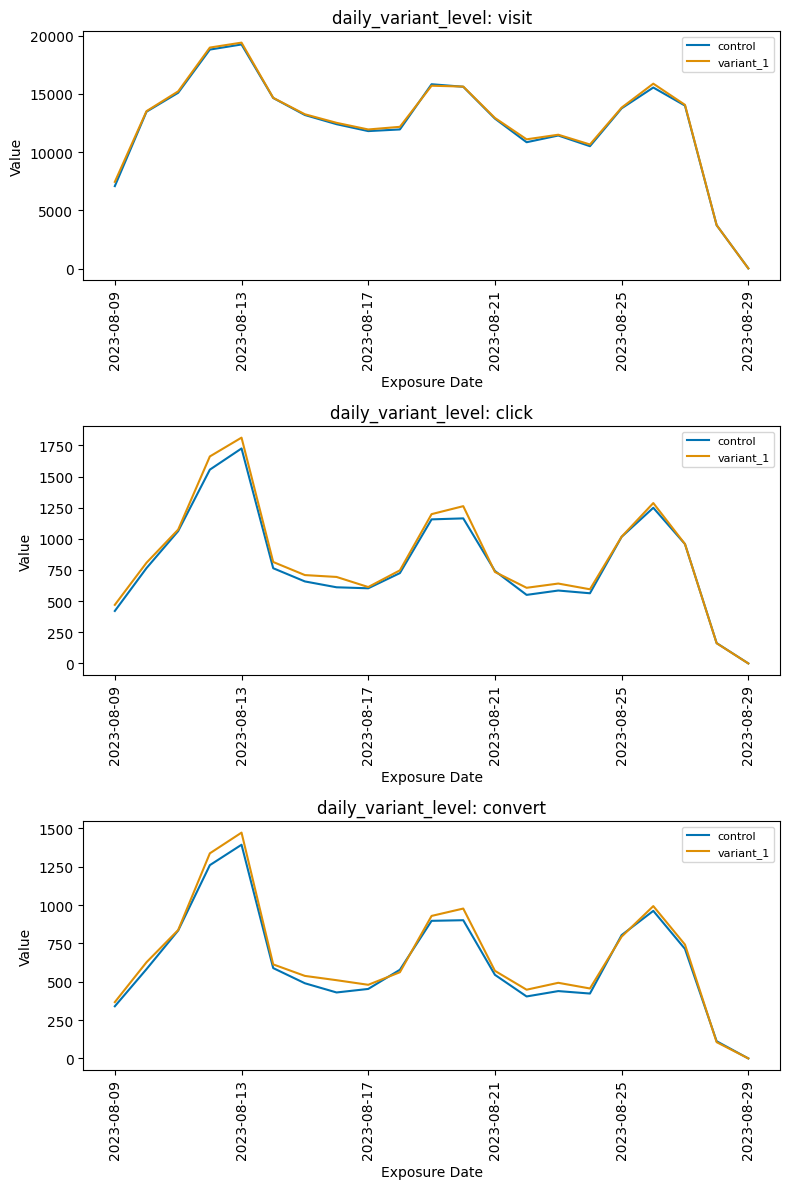

<Figure size 640x480 with 0 Axes>

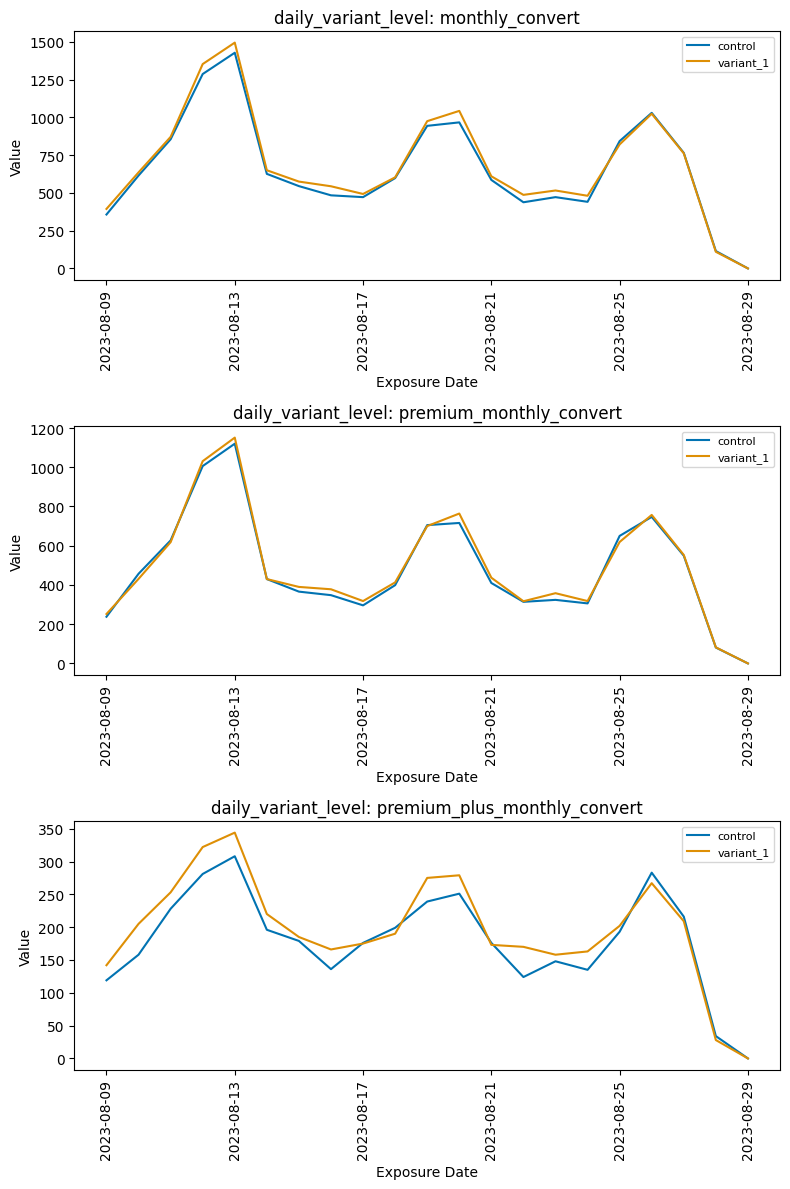

<Figure size 640x480 with 0 Axes>

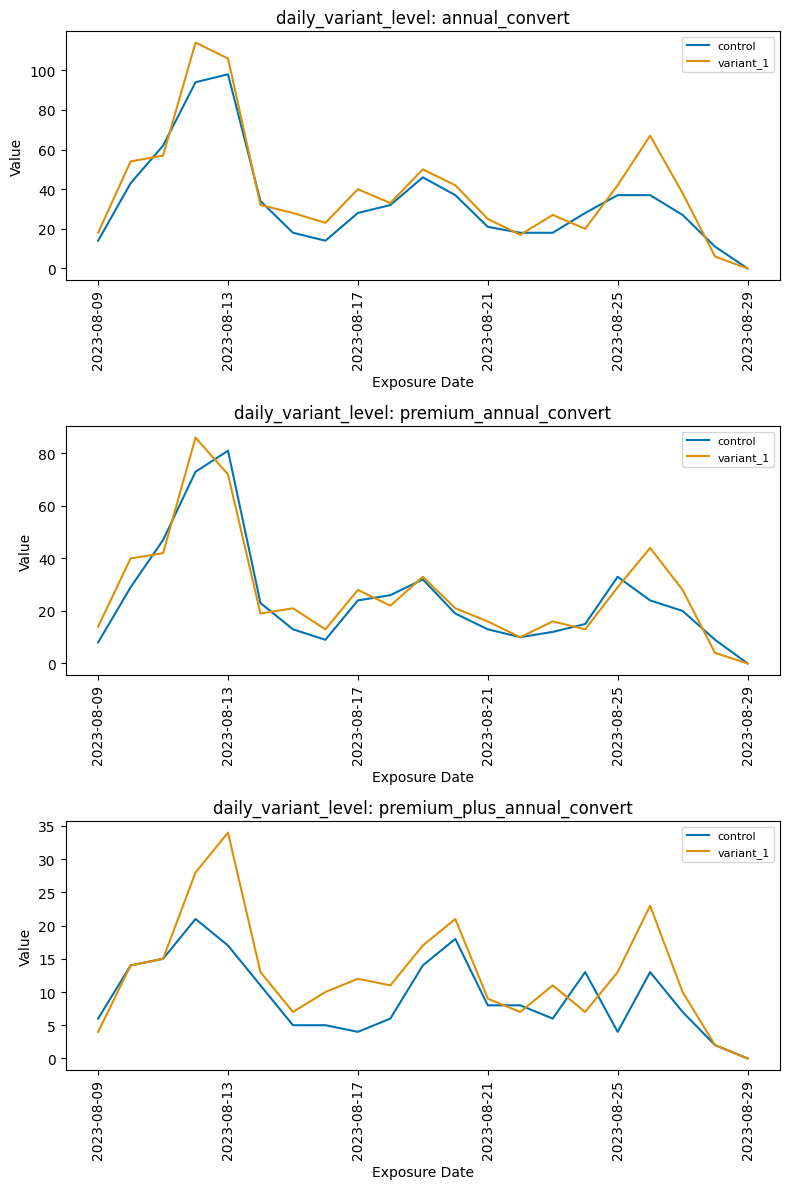

<Figure size 640x480 with 0 Axes>

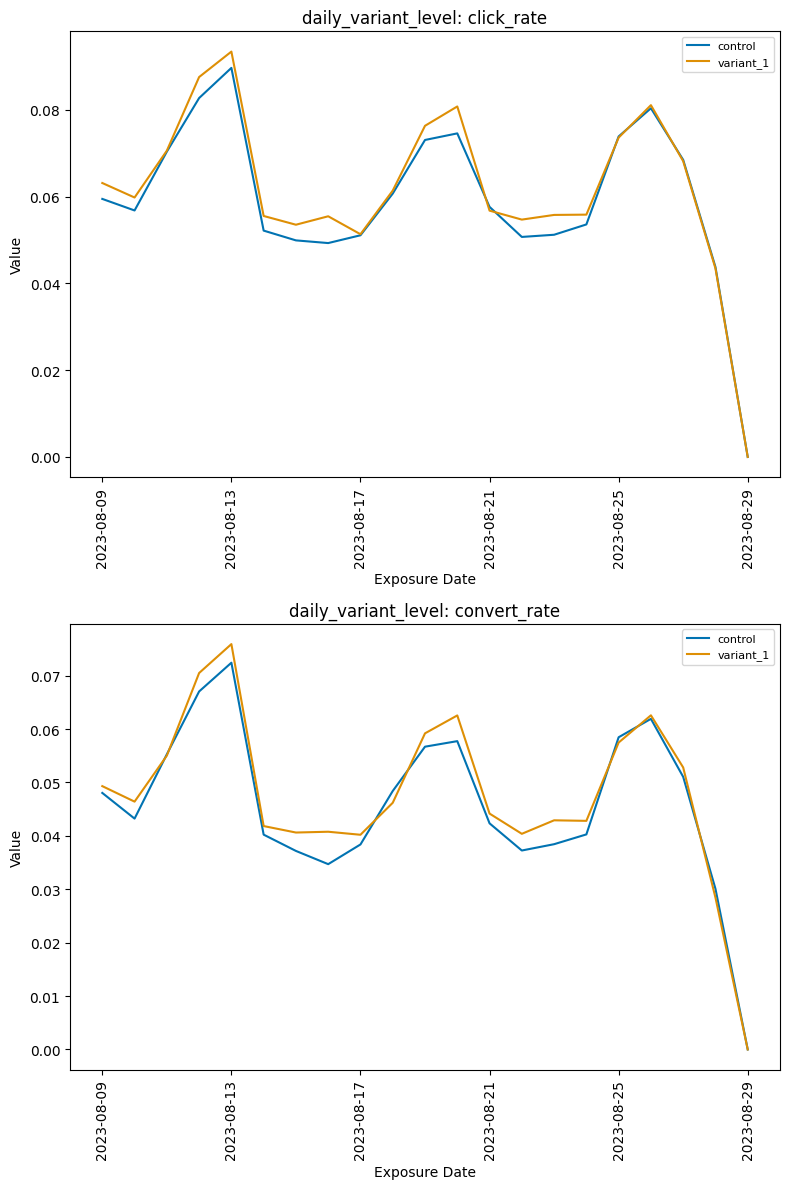

<Figure size 640x480 with 0 Axes>

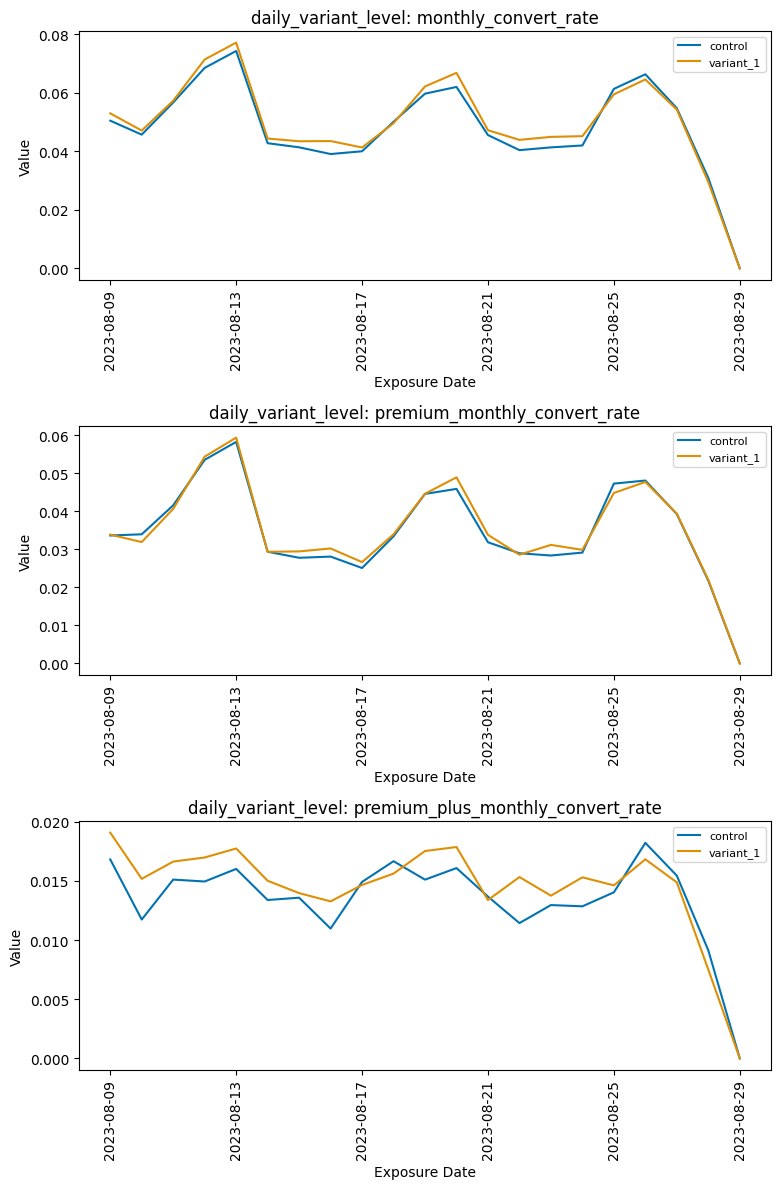

<Figure size 640x480 with 0 Axes>

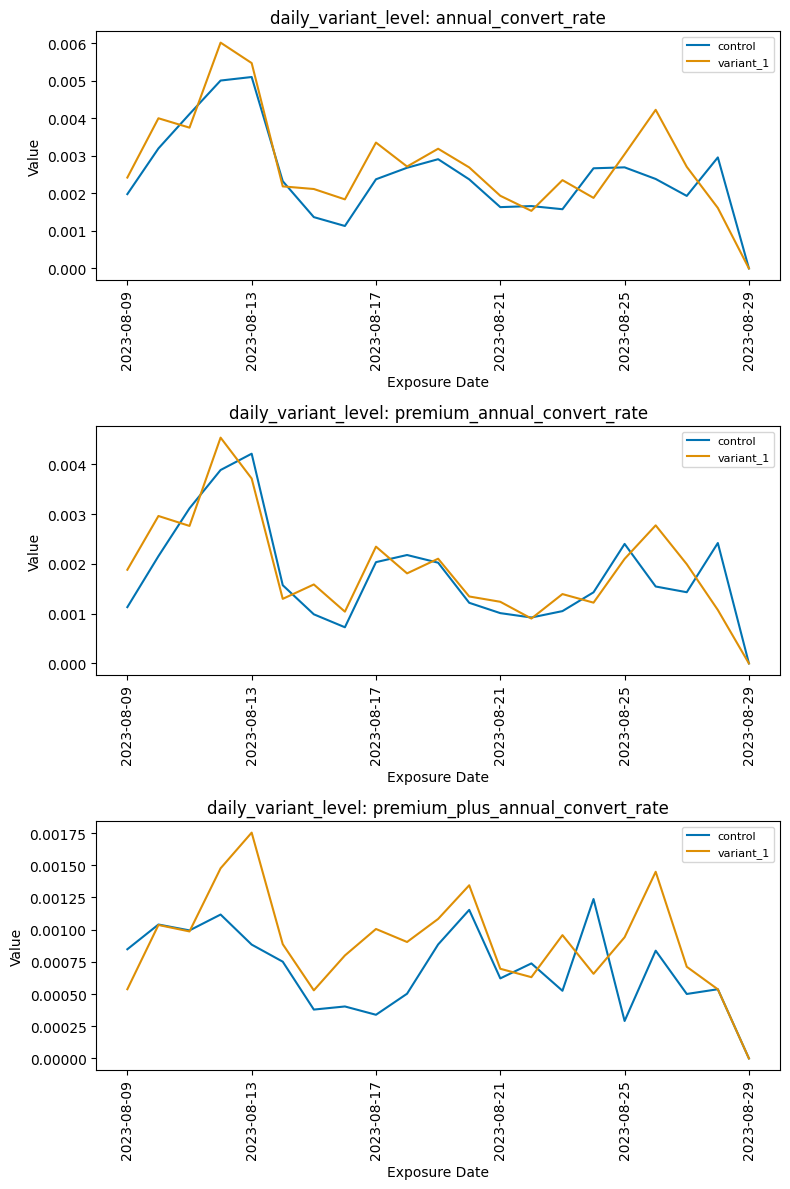

<Figure size 640x480 with 0 Axes>

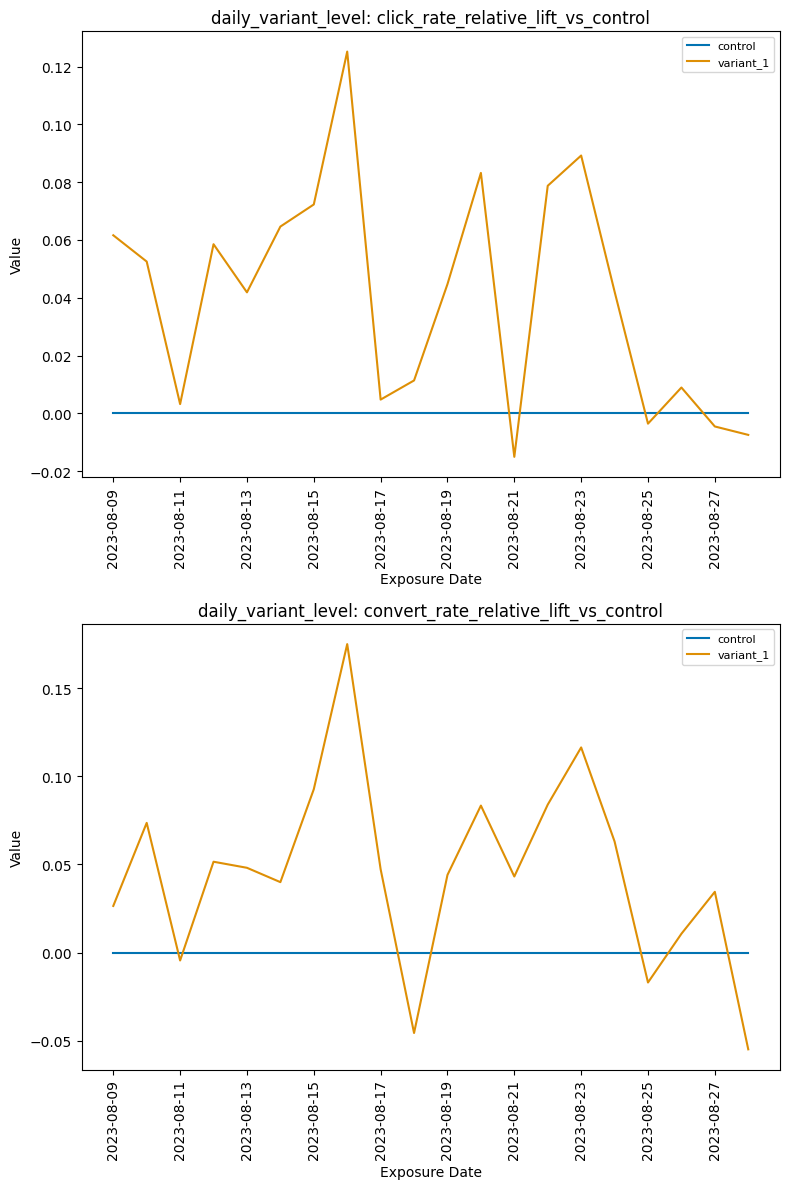

<Figure size 640x480 with 0 Axes>

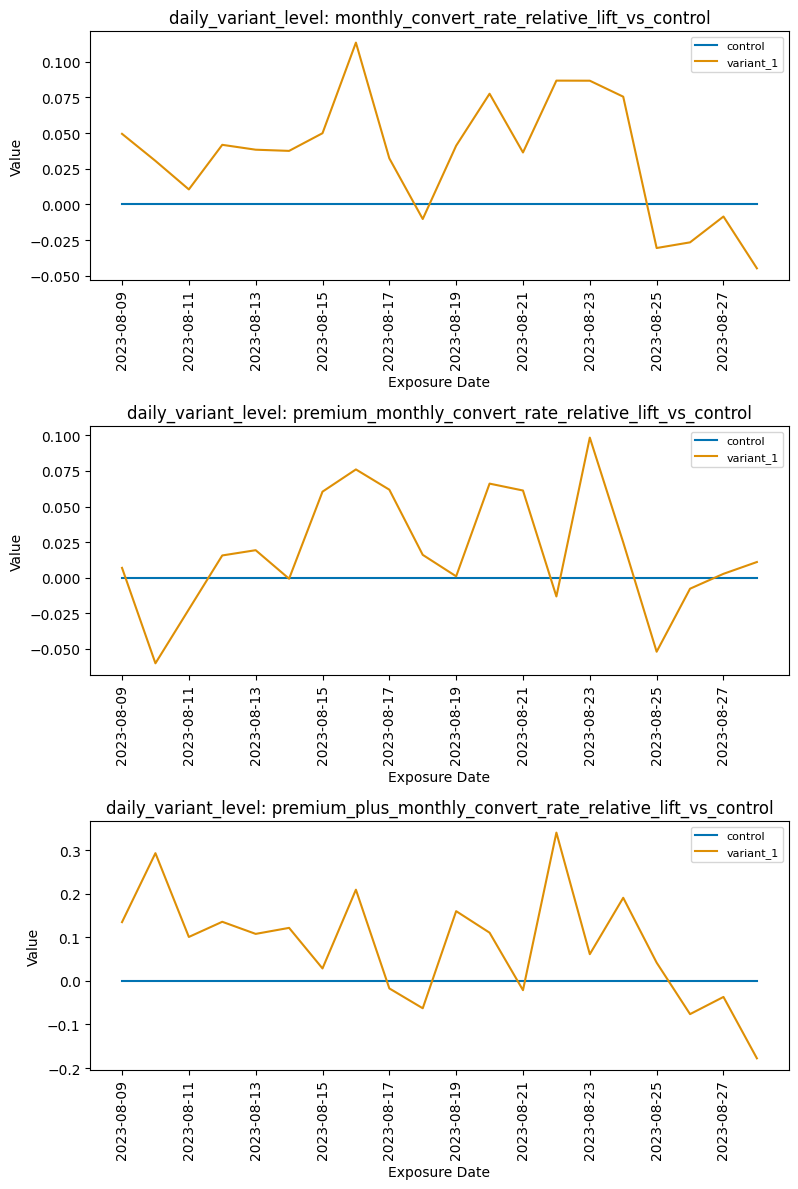

<Figure size 640x480 with 0 Axes>

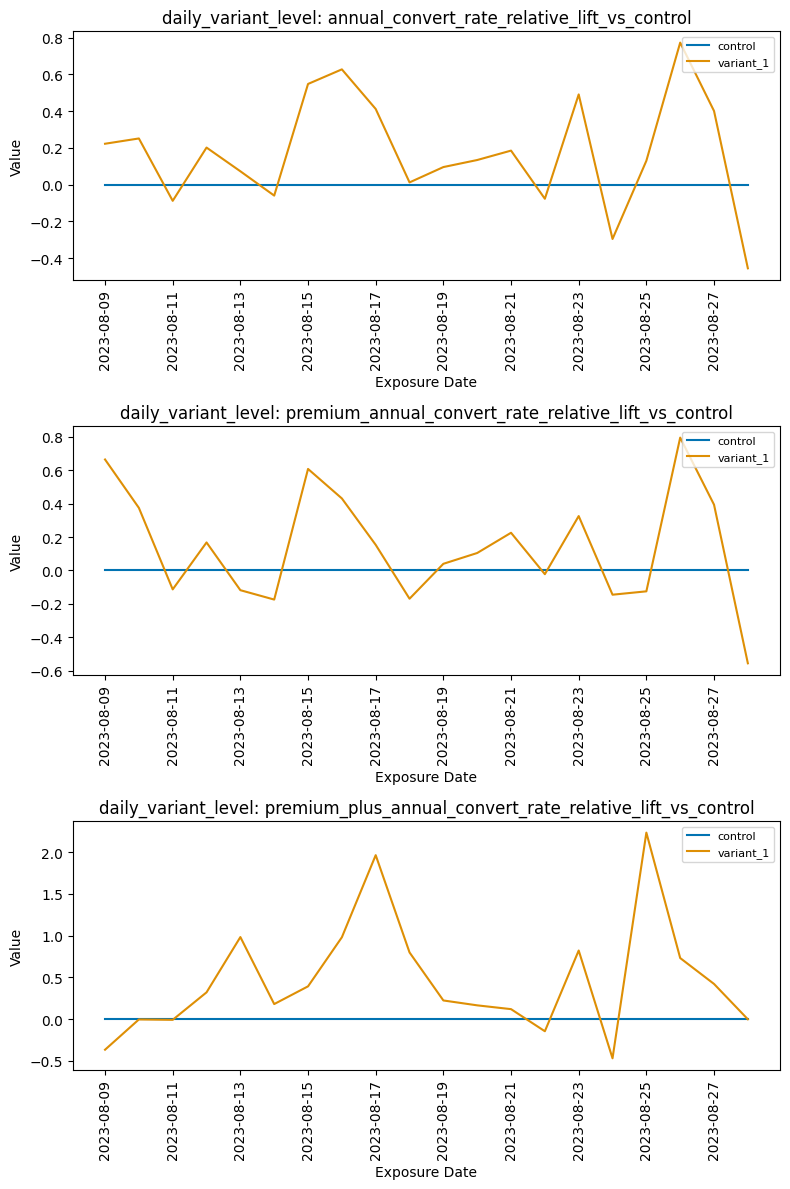

cumulative_daily_variant_level


<Figure size 640x480 with 0 Axes>

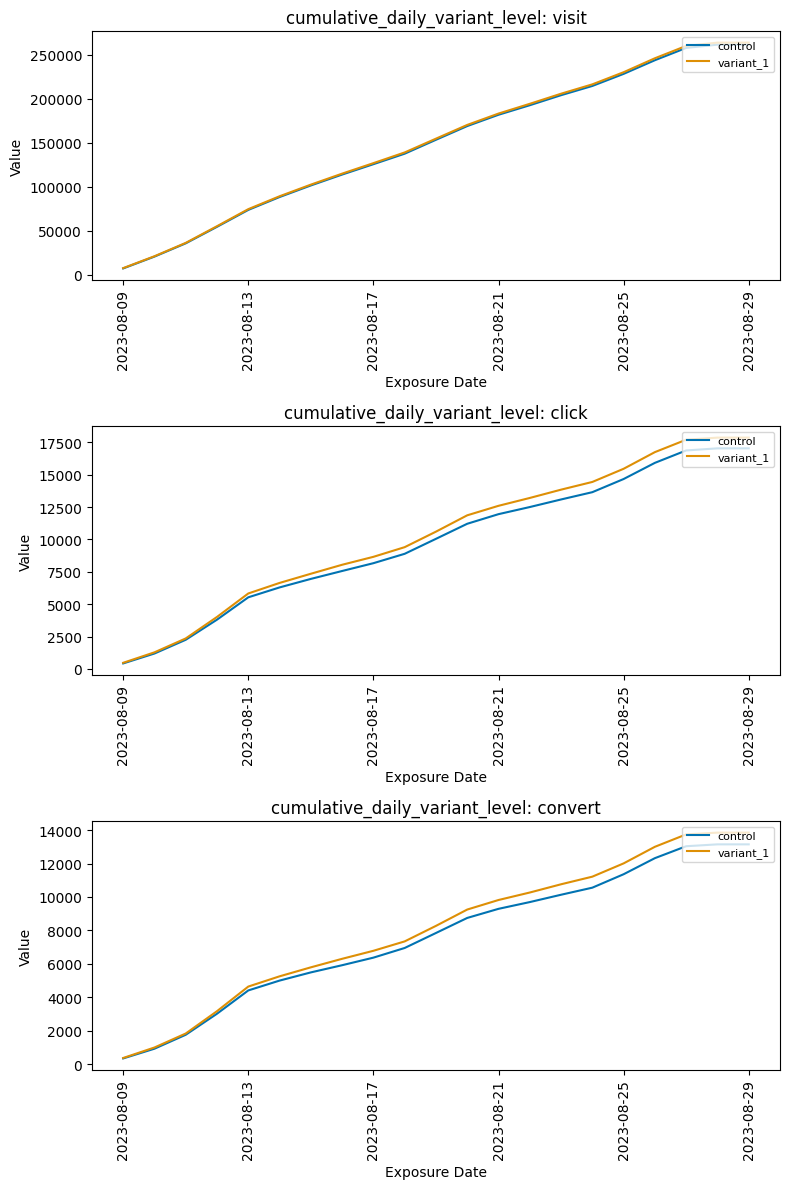

<Figure size 640x480 with 0 Axes>

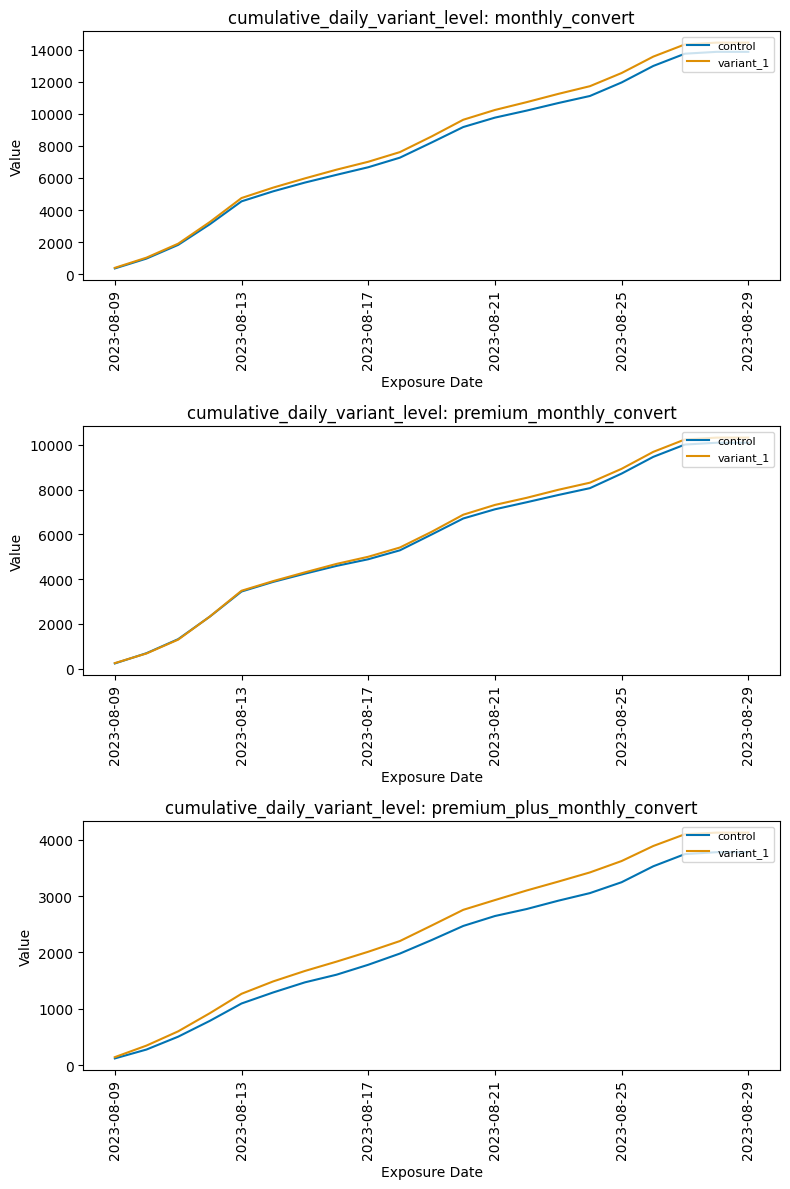

<Figure size 640x480 with 0 Axes>

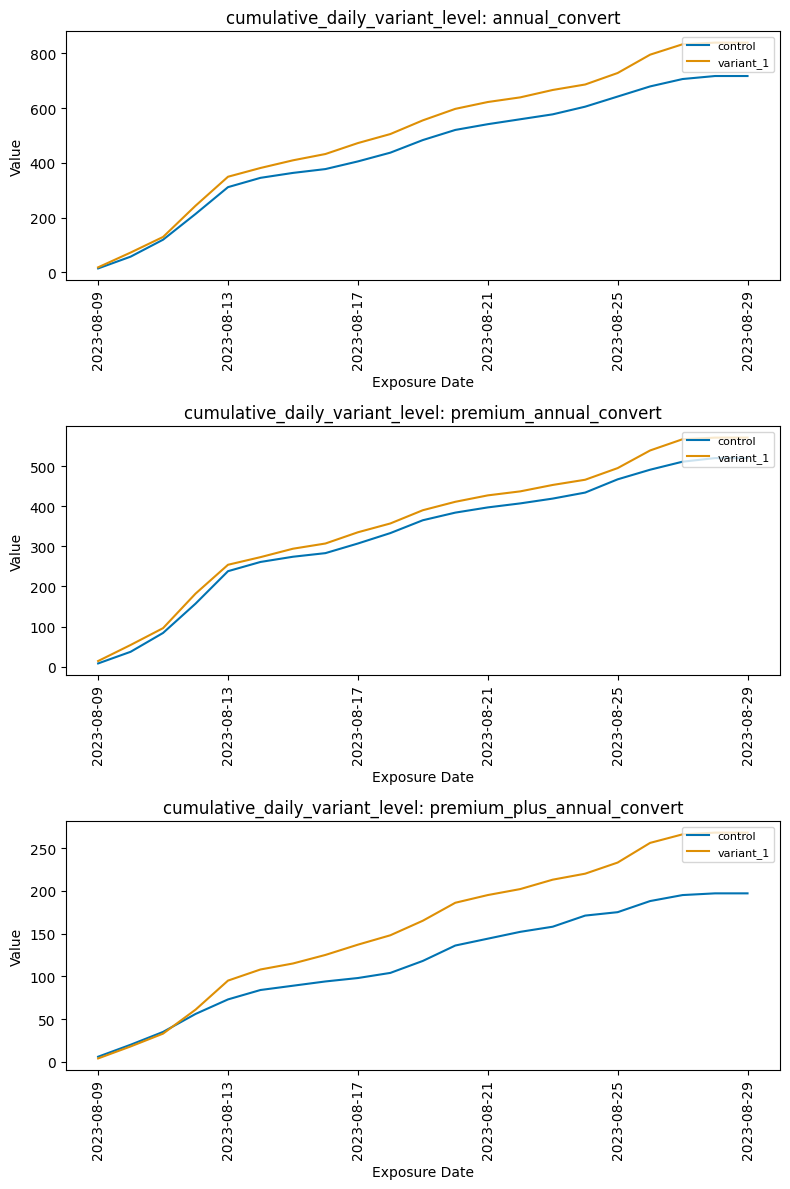

<Figure size 640x480 with 0 Axes>

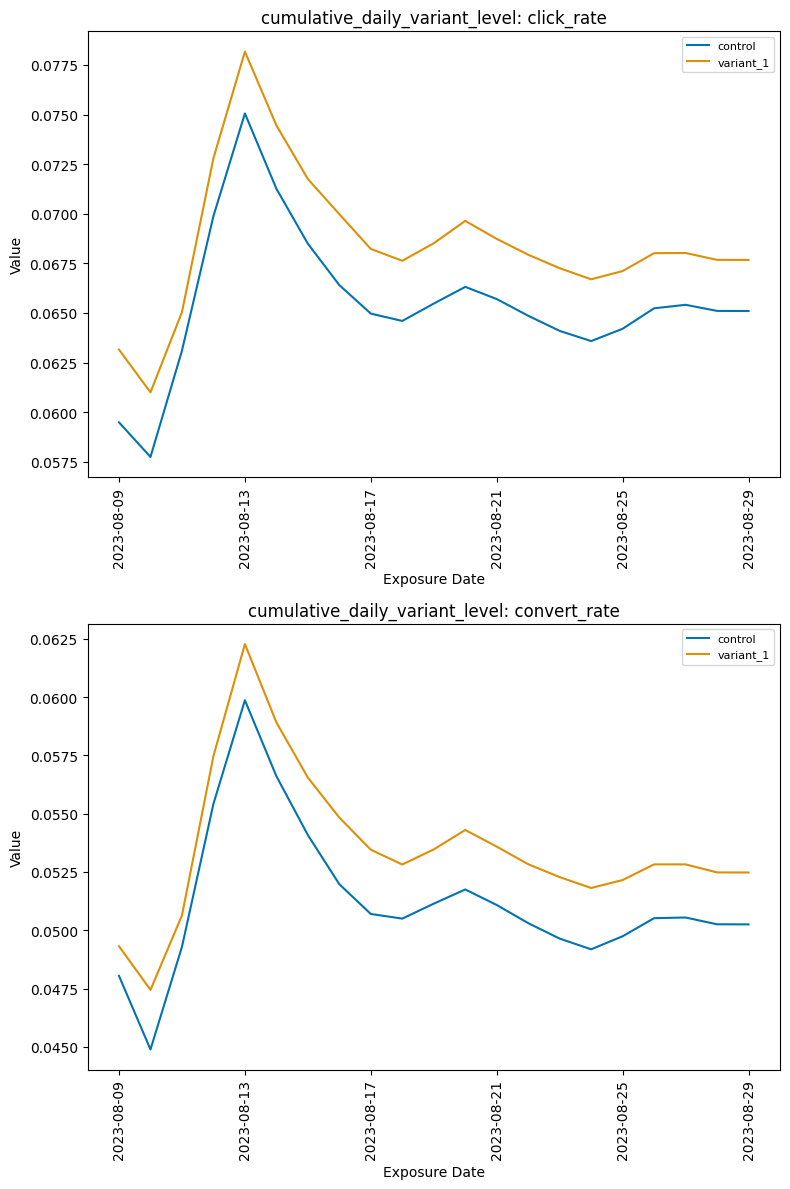

<Figure size 640x480 with 0 Axes>

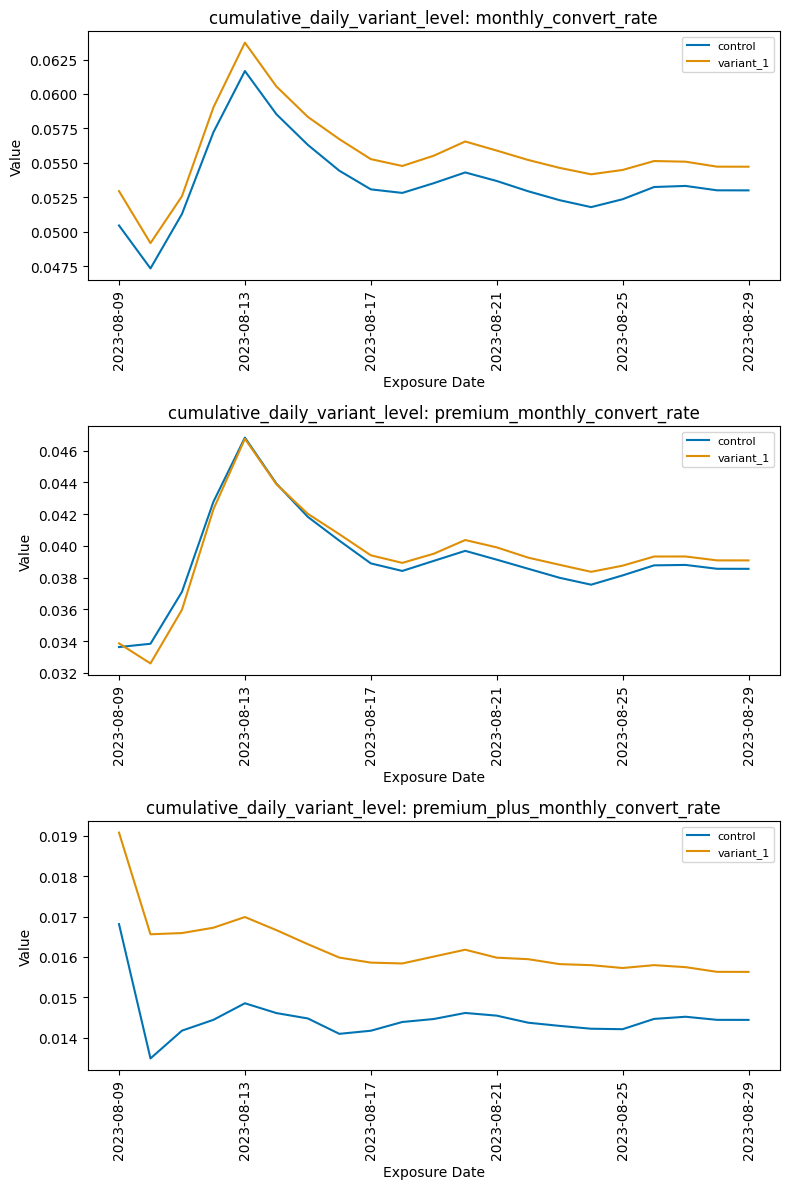

<Figure size 640x480 with 0 Axes>

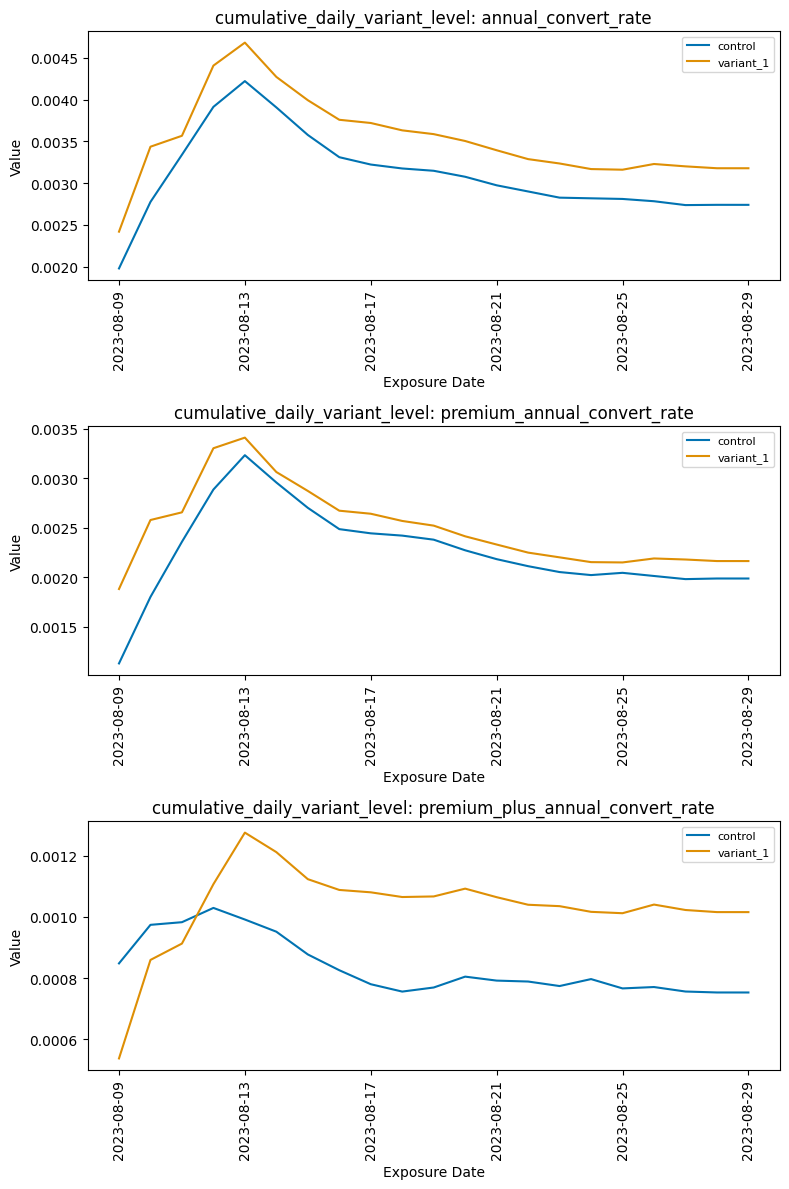

<Figure size 640x480 with 0 Axes>

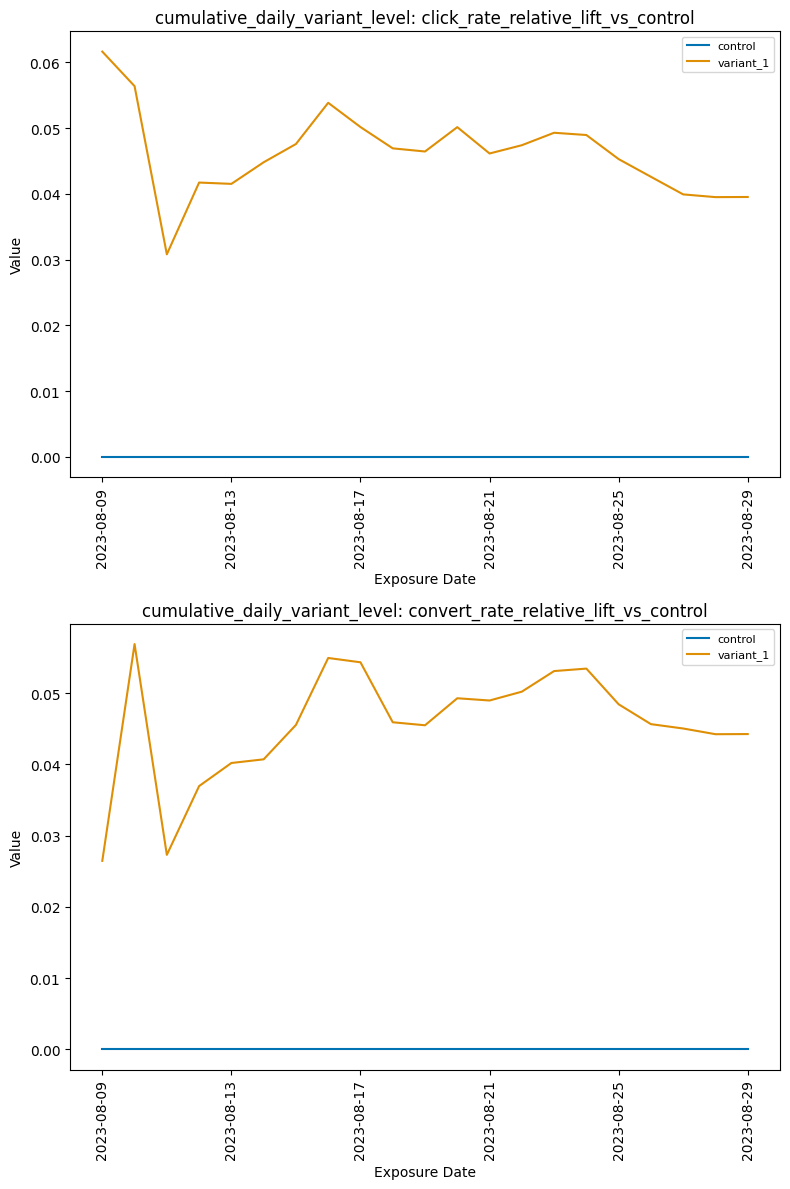

<Figure size 640x480 with 0 Axes>

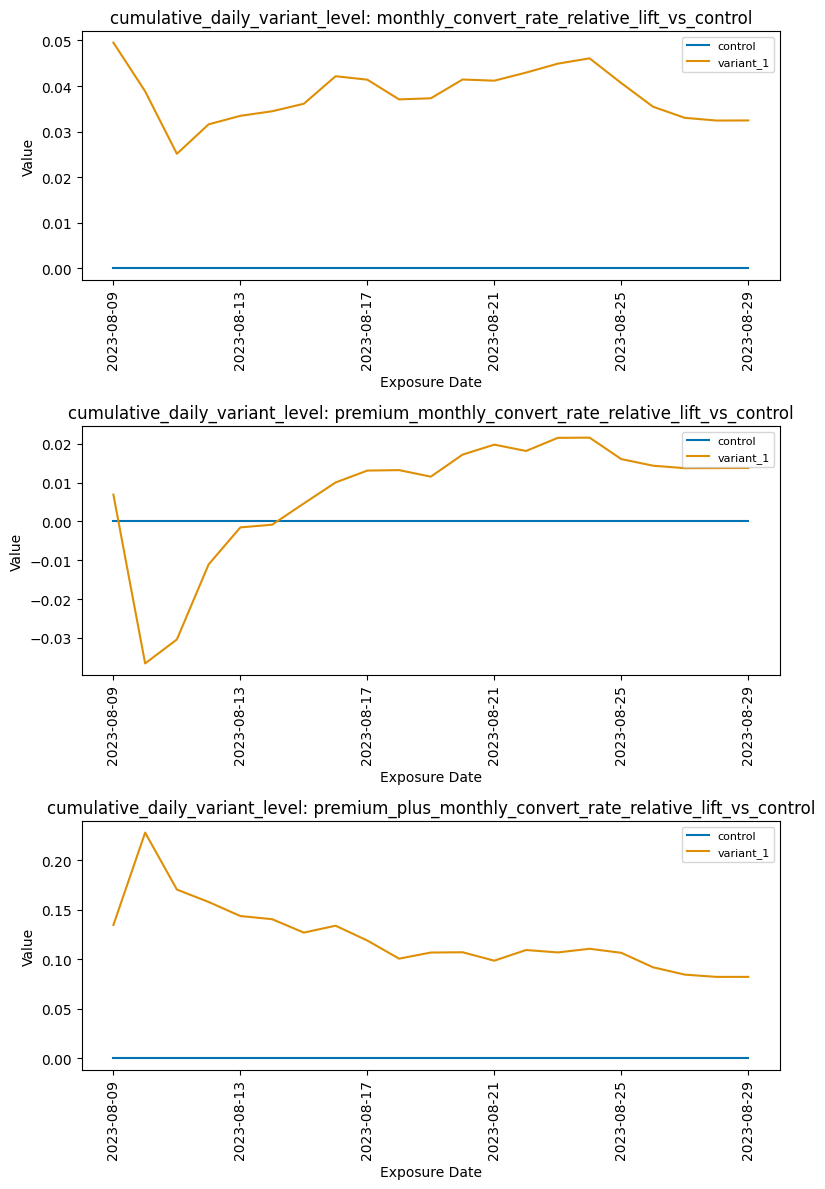

<Figure size 640x480 with 0 Axes>

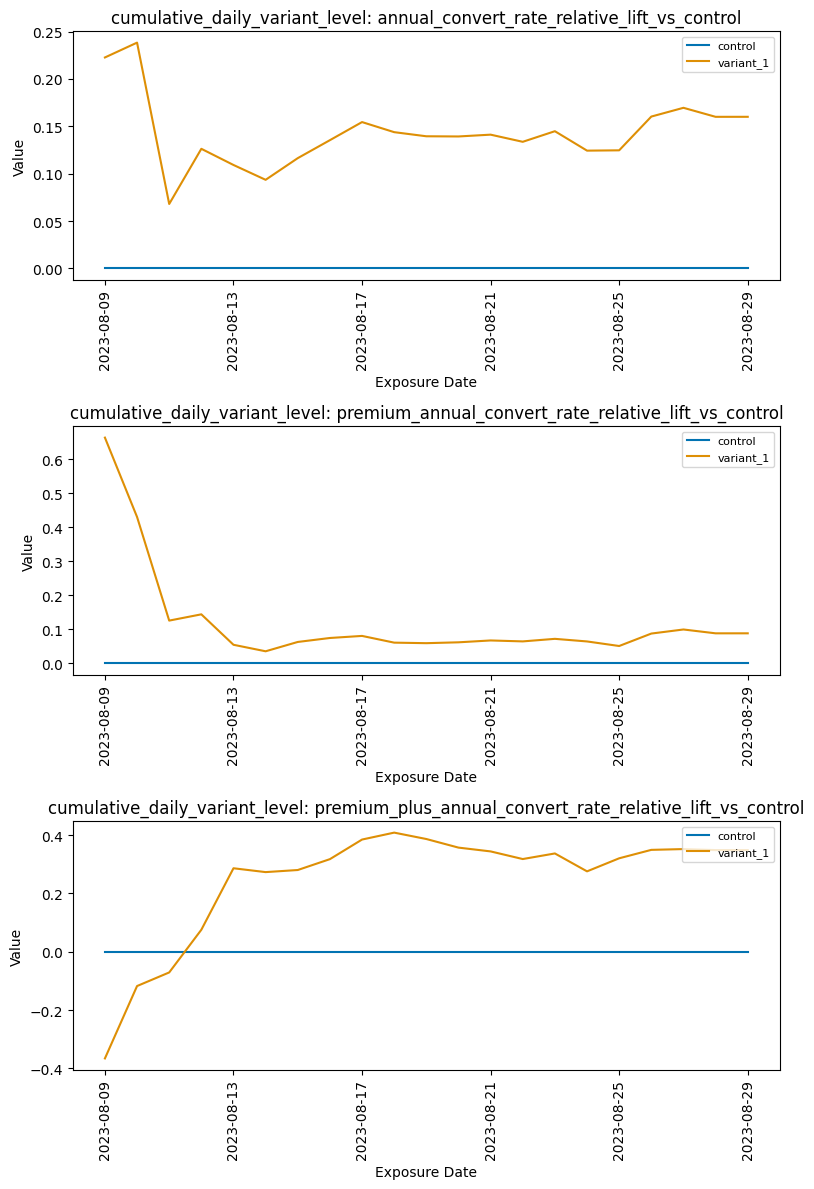

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Visualize Time Series Data
def visualize_experiment_data(data_dict):
    for k, v in data_dict.items():
        if k.find('daily_variant_level') >= 0:
            print(k)
            # Define metric groups
            metric_list_ov = ['visit', 'click', 'convert']
            metric_list_ov_fun = ['click', 'convert']
            metric_list_mc = ['monthly_convert', 'premium_monthly_convert', 'premium_plus_monthly_convert']
            metric_list_ac = ['annual_convert', 'premium_annual_convert', 'premium_plus_annual_convert']
            metric_list_ov_rate = [m + "_rate" for m in metric_list_ov_fun]
            metric_list_mc_rate = [m + "_rate" for m in metric_list_mc]
            metric_list_ac_rate = [m + "_rate" for m in metric_list_ac]

            metric_list_ov_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_ov_rate]
            metric_list_mc_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_mc_rate]
            metric_list_ac_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_ac_rate]

            metric_lol = [
                  metric_list_ov, metric_list_mc, metric_list_ac,
                  metric_list_ov_rate,metric_list_mc_rate,metric_list_ac_rate,
                  metric_list_ov_vs_control, metric_list_mc_vs_control, metric_list_ac_vs_control
            ]

            for metric_group in metric_lol:
                # Create a single set of subplots for each metric group
                fig, axes = plt.subplots(len(metric_group), 1, figsize=(8, 12))
                palette = sns.color_palette("colorblind")

                for a, metric in enumerate(metric_group):
                    ax = axes[a]


                    # if metric is relative_lift_vs_control, then dont plot control group
                    for i, variant_name in enumerate(v['variant_name'].unique()):
                        sub_v = v[v['variant_name'] == variant_name]
                        color = palette[i % len(palette)]
                        ax.plot(sub_v['bucketed_date'], sub_v[metric], label=variant_name, color=color)

                    ax.set_xlabel('Exposure Date')
                    ax.set_ylabel('Value')
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                    ax.set_title(f'{k}: {metric}')
                    ax.legend(loc='upper right',  frameon=True, fontsize=8)


                plt.tight_layout()
                plt.show()
                metric_string = "_".join(metric_group)
                fig.savefig(f"{output_vars['experiment_name']}_{metric_string}_{k}_.png")
                plt.clf()
        else:
            pass
visualize_experiment_data(agg_lifts_dict)

Visualizing overall_grain_level
0                           click_rate
1                         convert_rate
2         premium_monthly_convert_rate
3    premium_plus_monthly_convert_rate
4          premium_annual_convert_rate
5     premium_plus_annual_convert_rate
6                 monthly_convert_rate
7                  annual_convert_rate
8                 premium_convert_rate
9            premium_plus_convert_rate
Name: metric, dtype: object


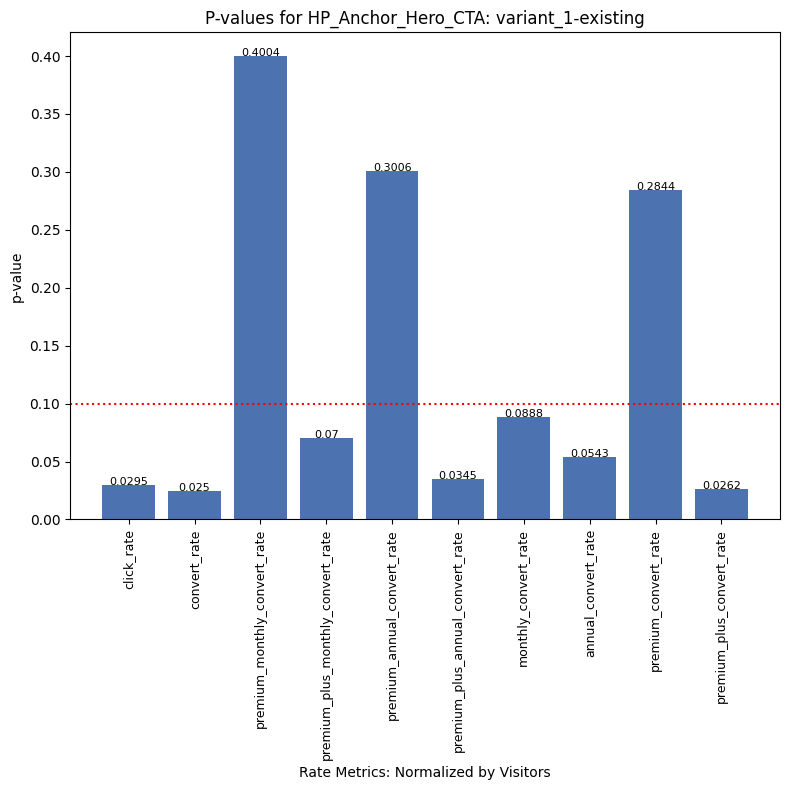

<Figure size 640x480 with 0 Axes>

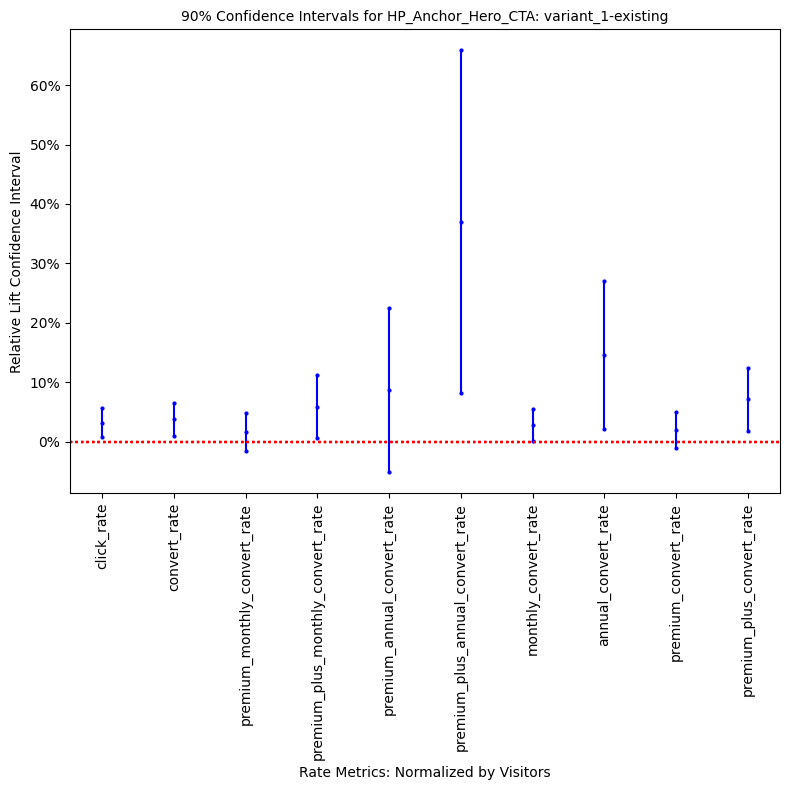

10                           click_rate
11                         convert_rate
12         premium_monthly_convert_rate
13    premium_plus_monthly_convert_rate
14          premium_annual_convert_rate
15     premium_plus_annual_convert_rate
16                 monthly_convert_rate
17                  annual_convert_rate
18                 premium_convert_rate
19            premium_plus_convert_rate
Name: metric, dtype: object


<Figure size 640x480 with 0 Axes>

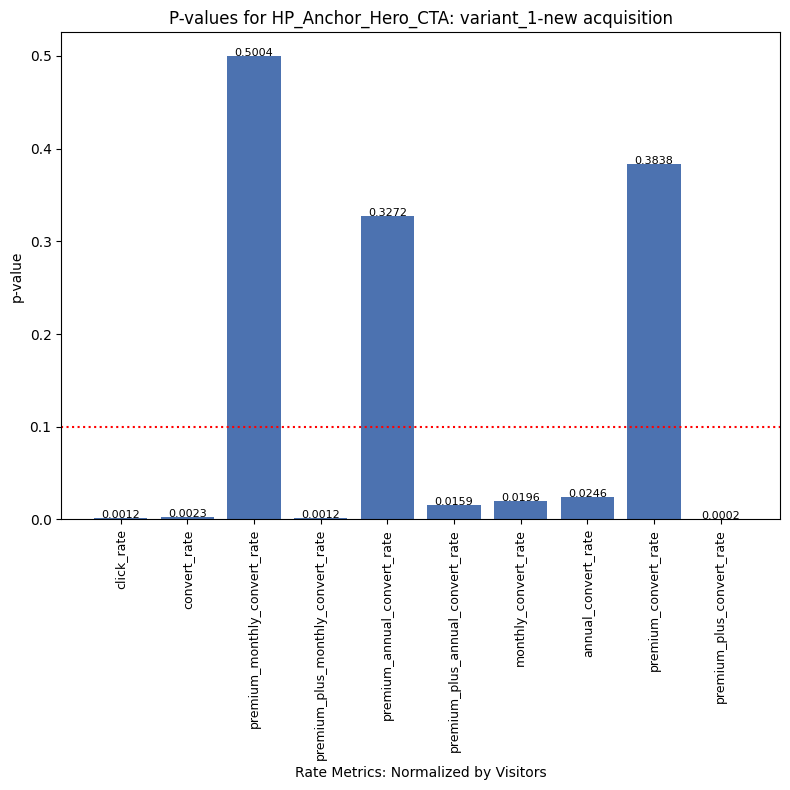

<Figure size 640x480 with 0 Axes>

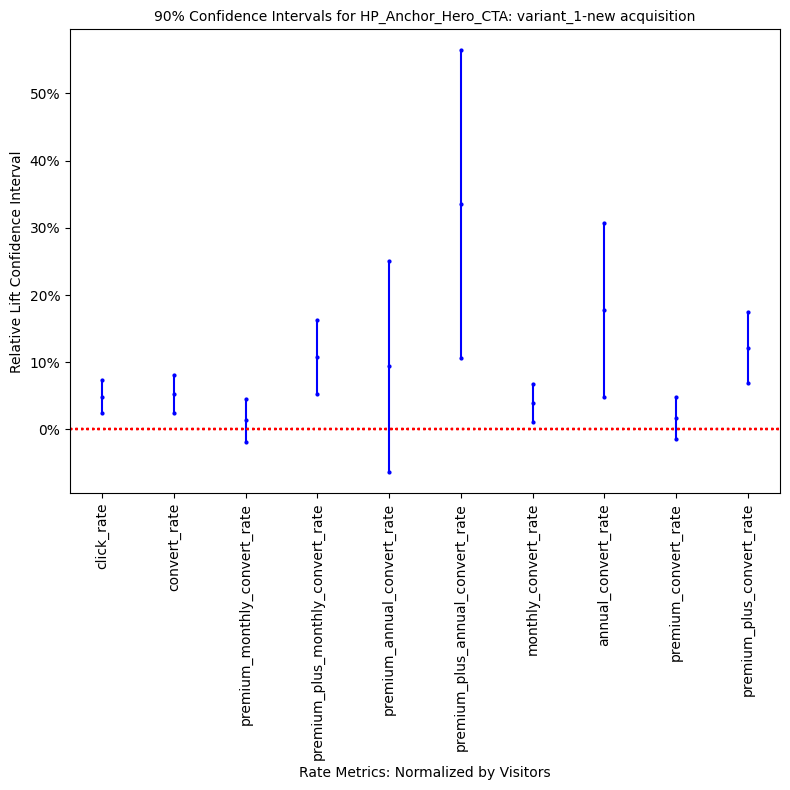

Visualizing overall_variant_level
0                           click_rate
1                         convert_rate
2         premium_monthly_convert_rate
3    premium_plus_monthly_convert_rate
4          premium_annual_convert_rate
5     premium_plus_annual_convert_rate
6                 monthly_convert_rate
7                  annual_convert_rate
8                 premium_convert_rate
9            premium_plus_convert_rate
Name: metric, dtype: object


<Figure size 640x480 with 0 Axes>

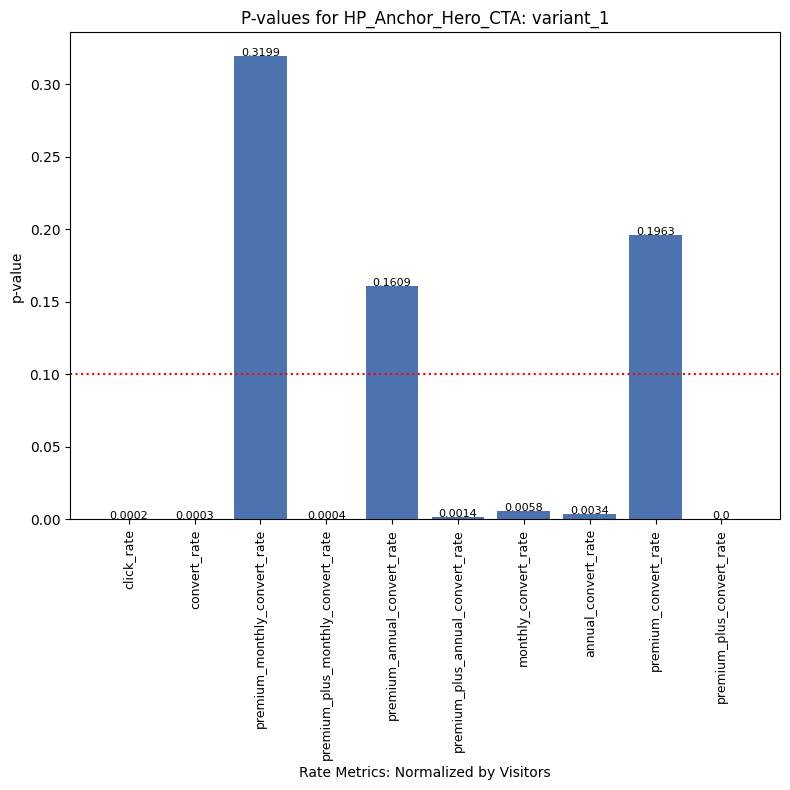

<Figure size 640x480 with 0 Axes>

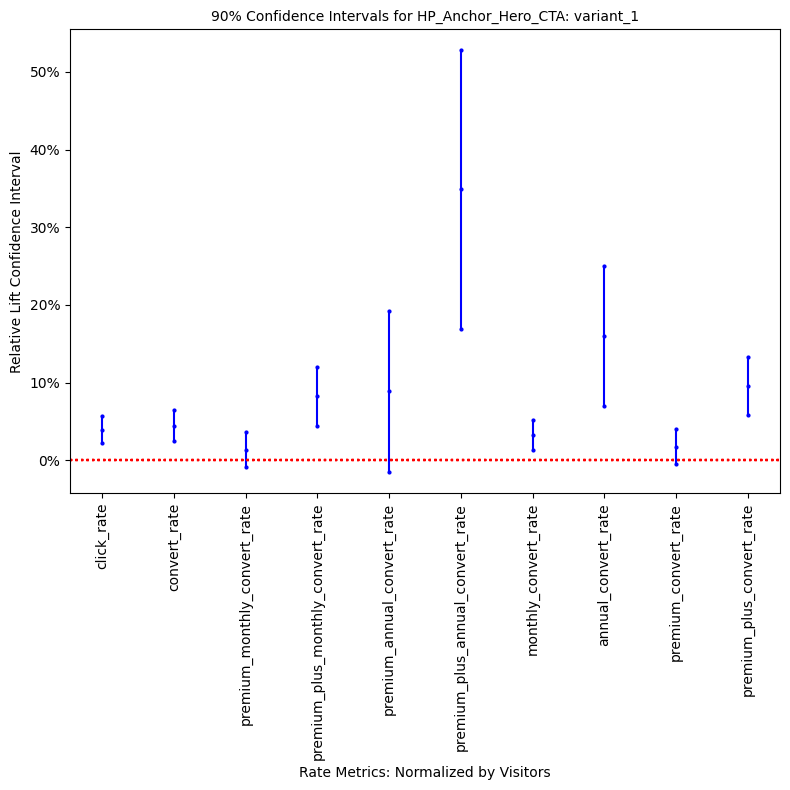

In [ ]:
# @title Visualize Hypothesis Testing Data
def visualize_hyp_data(dict):
  """
  cycle through dictionary of hyp data frames
  plot p-values for each metric with significance line
  plot relative lift confidence intervals for each metric
  Note: each metric in hyp dict is expressed as a rate (normalized by visitors)
  """
  for k,v in dict.items():
    print("Visualizing", k)
    group_list = v['variant_group'].unique().tolist()
    #set up subplots
    plt.style.use('seaborn-deep')
    for id, g in enumerate(group_list):
      plt.figure(figsize = (8,8))
      #subset data frame to just 1 group
      sub_v = v[v['variant_group'] == g]
      #plot, name and save p-values
      plt.bar(sub_v['metric'], sub_v['p_value'])
      print(sub_v['metric'])
      #plot data labels
      for i, val in enumerate(sub_v['p_value']):
        plt.text(i, val, round(val,4), ha = 'center', fontsize = 8)
      plt.xticks(fontsize=9, rotation=90)
      plt.yticks(fontsize=10)
      plt.xlabel("Rate Metrics: Normalized by Visitors", size=10)
      plt.ylabel("p-value", size=10)
      plt.title("P-values for "+ output_vars['experiment_name'] + ': ' + g, size=12)
      plt.axhline(y=0.1, color='red', linestyle='dotted', label='Threshold (0.1)')  # Add the dotted line
      plt.tight_layout()
      plt.savefig(f"{output_vars['experiment_name']}_{k}_group_{g}_pvals.png")
      plt.show()
      plt.clf()

      #plot name and save confidence interval
      plt.figure(figsize = (8,8))
      def percentage_formatter(x, pos):
        return f'{x * 100:.0f}%'
      for x, lower,relative, upper in zip(range(len(sub_v)), sub_v['ci_lower_relative'],sub_v['relative_diff'], sub_v['ci_upper_relative']):
        plt.plot((x,x,x),(lower,relative,upper), 'o-',color='blue', markersize = 2)
        plt.xticks(range(len(sub_v)),list(sub_v['metric']), rotation = 90)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        plt.xlabel("Rate Metrics: Normalized by Visitors", size=10)
        plt.ylabel("Relative Lift Confidence Interval", size=10)
        plt.title(str(percentage_formatter(1- hyp_test_vars['alpha'],0))+ " Confidence Intervals for "+ output_vars['experiment_name'] + ': ' + g, size=10)
        plt.axhline(y=0.0, color='red', linestyle='dotted')
      plt.tight_layout()
      plt.savefig(f"{output_vars['experiment_name']}_{k}_group_{g}_relative_lift_confidence_intervals.png")
      plt.show()
      plt.clf()
  plt.close()
  pass
#run function
visualize_hyp_data(hypothesis_dict)